In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import pandas as pd
import numpy as np
import h5py
import json
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
train_input = torch.from_numpy(np.load("/content/cite_train_X.npy"))
print(train_input.shape)
target = h5py.File('/content/cite_train_y.h5', 'r')
target_df = pd.read_hdf('/content/cite_train_y.h5')
np.save('/content/cite_train_y.npy', target_df.to_numpy())

torch.Size([70988, 553])


In [ ]:
# Save protein name in order
target_protiens = list(target_df.columns)
x = json.dumps(target_protiens)
with open("/content/protein_list.json", "w") as outfile:
    json.dump(x, outfile)

In [ ]:
train_target = torch.from_numpy(target_df.to_numpy())
print(train_target.shape)

torch.Size([70988, 140])


In [ ]:
traindata = train_input[:50000]
validdata = train_input[50000:]
trainlabels = train_target[:50000]
validlabels = train_target[50000:]
cite_train = TensorDataset(traindata, trainlabels)
cite_valid = TensorDataset(validdata, validlabels)
cite_train_loader = DataLoader(cite_train, batch_size=128)
cite_valid_loader = DataLoader(cite_valid, batch_size=128)

In [ ]:
test_input = torch.from_numpy(np.load("/content/cite_test_X.npy"))

In [ ]:
def correlation_score(y_true, y_pred):
    """
    Scores the predictions according to the competition rules. 
    It is assumed that the predictions are not constant.
    Returns the average of each sample's Pearson correlation coefficient
    """
    
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

device = 'cpu'
def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    current_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = criterion(pred, y)
        current_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and batch != 0:
          average_loss, current = current_loss/(batch*len(X)), batch * len(X)
          print(f"loss: {average_loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, criterion):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, cor = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += criterion(pred, y).item()
      cor += correlation_score(y, pred)

  avg_loss = test_loss / size
  cor /= num_batches
  print(f"Test Error: \n Correlation: {(100*cor):>0.1f}%, Avg loss: {avg_loss:>8f} \n, loss: {test_loss:>8f} \n")

In [ ]:
class MLP(nn.Module): 
    def __init__(self):
        super(MLP, self).__init__()
        self.input_ = nn.Linear(553, 2048)
        self.fc = nn.Linear(2048, 2048)
        self.fc1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.25)
        self.output = nn.Linear(512, 140)
    def forward(self, x):
        x = nn.functional.gelu(self.input_(x))
        x = self.dropout1(x)
        x = nn.functional.gelu(self.fc(x))
        x = self.dropout2(x)
        x = nn.functional.gelu(self.fc1(x))
        x = self.dropout3(x)
        x = nn.functional.gelu(self.output(x))
        return x

In [ ]:
mlp = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer_w = optim.AdamW(mlp.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)

In [ ]:
n_epoch = 30
for i in range(n_epoch):
  train(cite_train_loader, mlp, criterion, optimizer)
  test(cite_valid_loader, mlp, criterion)

loss: 0.019082  [12800/50000]
loss: 0.020901  [25600/50000]
loss: 0.025735  [38400/50000]
Test Error: 
 Correlation: 85.6%, Avg loss: 0.027517 
, loss: 577.535227 

loss: 0.018646  [12800/50000]
loss: 0.020449  [25600/50000]
loss: 0.024910  [38400/50000]
Test Error: 
 Correlation: 85.7%, Avg loss: 0.026601 
, loss: 558.311313 

loss: 0.018944  [12800/50000]
loss: 0.020245  [25600/50000]
loss: 0.024665  [38400/50000]
Test Error: 
 Correlation: 85.5%, Avg loss: 0.026825 
, loss: 563.000087 

loss: 0.018433  [12800/50000]
loss: 0.019909  [25600/50000]
loss: 0.024940  [38400/50000]
Test Error: 
 Correlation: 85.5%, Avg loss: 0.027514 
, loss: 577.455250 

loss: 0.018116  [12800/50000]
loss: 0.019795  [25600/50000]
loss: 0.025047  [38400/50000]
Test Error: 
 Correlation: 85.4%, Avg loss: 0.026493 
, loss: 556.031508 

loss: 0.018195  [12800/50000]
loss: 0.020010  [25600/50000]
loss: 0.024933  [38400/50000]
Test Error: 
 Correlation: 85.5%, Avg loss: 0.026456 
, loss: 555.267467 

loss: 0.01

In [ ]:
from sklearn.metrics import mean_squared_error
pred = mlp(validdata)
print(type(pred))
print(type(validlabels))
mse = mean_squared_error(pred.detach().numpy(), validlabels.detach().numpy())
cor = correlation_score(pred.detach().numpy(), validlabels.detach().numpy())
print(f'mse: {mse}, cor: {cor}')

<class 'torch.Tensor'>
<class 'torch.Tensor'>
mse: 3.4813132286071777, cor: 0.8538795414037409


In [ ]:
torch.save(mlp.state_dict(), '/content/mlp_10.pth')

In [ ]:
# n_epoch = 10
# for i in range(n_epoch):
#   train(cite_train_loader, mlp, criterion, optimizer_w)
#   test(cite_valid_loader, mlp, criterion)

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 30.9 MB/s eta 0:00:00


In [ ]:
import shap
input, _ = next(iter(cite_valid_loader))

background = input[:110]
test = input[110:]

e = shap.DeepExplainer(mlp, input)
shap_values = e.shap_values(test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
len(shap_values)

140

In [ ]:
features_names = []
for i in range(512):
  features_names.append(f"tsvd_{i}")

In [ ]:
features_names.extend(['BP', 'EryP', 'HSC',	'MasP',	'MkP',	'MoP',	'NeuP'])
gene_name = ['ENSG00000134256_CD101', 'ENSG00000170458_CD14', 'ENSG00000177575_CD163', 'ENSG00000177455_CD19', 'ENSG00000116824_CD2', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000139193_CD27', 'ENSG00000120217_CD274', 'ENSG00000105383_CD33', 'ENSG00000135218_CD36', 'ENSG00000004468_CD38', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000026508_CD44', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000169442_CD52', 'ENSG00000116815_CD58', 'ENSG00000135404_CD63', 'ENSG00000110848_CD69', 'ENSG00000173762_CD7', 'ENSG00000137101_CD72', 'ENSG00000110651_CD81', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000114013_CD86', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000168329_CX3CR1', 'ENSG00000204592_HLA-E', 'ENSG00000139187_KLRG1']
features_names.extend(gene_name)

In [ ]:
correnspond_gene_pro = {}
for i, gene in enumerate(gene_name):
  for j, pro in enumerate(target_protiens):
    if gene.split('_')[1] == pro:
      print(f"gene_{gene}: {i} ---- {pro}: {j}")
      correnspond_gene_pro[j] = f"gene_{gene}: {i} ---- {pro}: {j}"


gene_ENSG00000134256_CD101: 0 ---- CD101: 137
gene_ENSG00000170458_CD14: 1 ---- CD14: 25
gene_ENSG00000177575_CD163: 2 ---- CD163: 91
gene_ENSG00000177455_CD19: 3 ---- CD19: 13
gene_ENSG00000116824_CD2: 4 ---- CD2: 95
gene_ENSG00000012124_CD22: 5 ---- CD22: 107
gene_ENSG00000150637_CD226: 6 ---- CD226: 96
gene_ENSG00000272398_CD24: 7 ---- CD24: 71
gene_ENSG00000122223_CD244: 8 ---- CD244: 75
gene_ENSG00000139193_CD27: 9 ---- CD27: 53
gene_ENSG00000120217_CD274: 10 ---- CD274: 1
gene_ENSG00000105383_CD33: 11 ---- CD33: 14
gene_ENSG00000135218_CD36: 12 ---- CD36: 113
gene_ENSG00000004468_CD38: 13 ---- CD38: 104
gene_ENSG00000010610_CD4: 14 ---- CD4: 23
gene_ENSG00000101017_CD40: 15 ---- CD40: 7
gene_ENSG00000026508_CD44: 16 ---- CD44: 24
gene_ENSG00000196776_CD47: 17 ---- CD47: 5
gene_ENSG00000117091_CD48: 18 ---- CD48: 6
gene_ENSG00000169442_CD52: 19 ---- CD52: 9
gene_ENSG00000116815_CD58: 20 ---- CD58: 68
gene_ENSG00000135404_CD63: 21 ---- CD63: 111
gene_ENSG00000110848_CD69: 22 ---- C

In [ ]:
# ! rm -rf /content/shap_plot

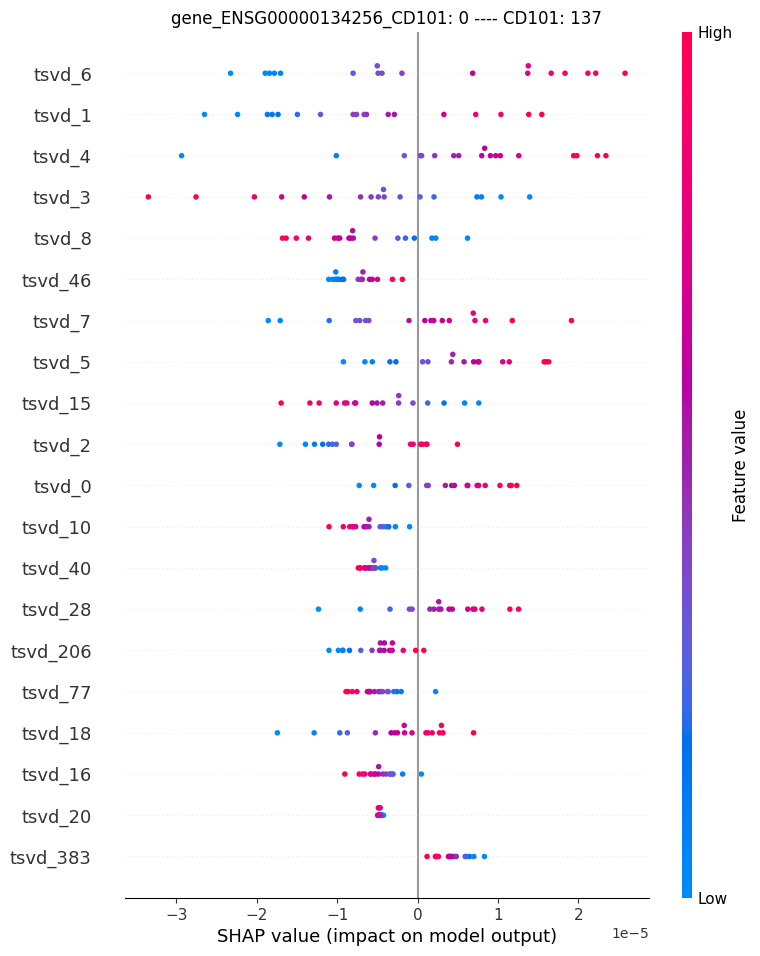

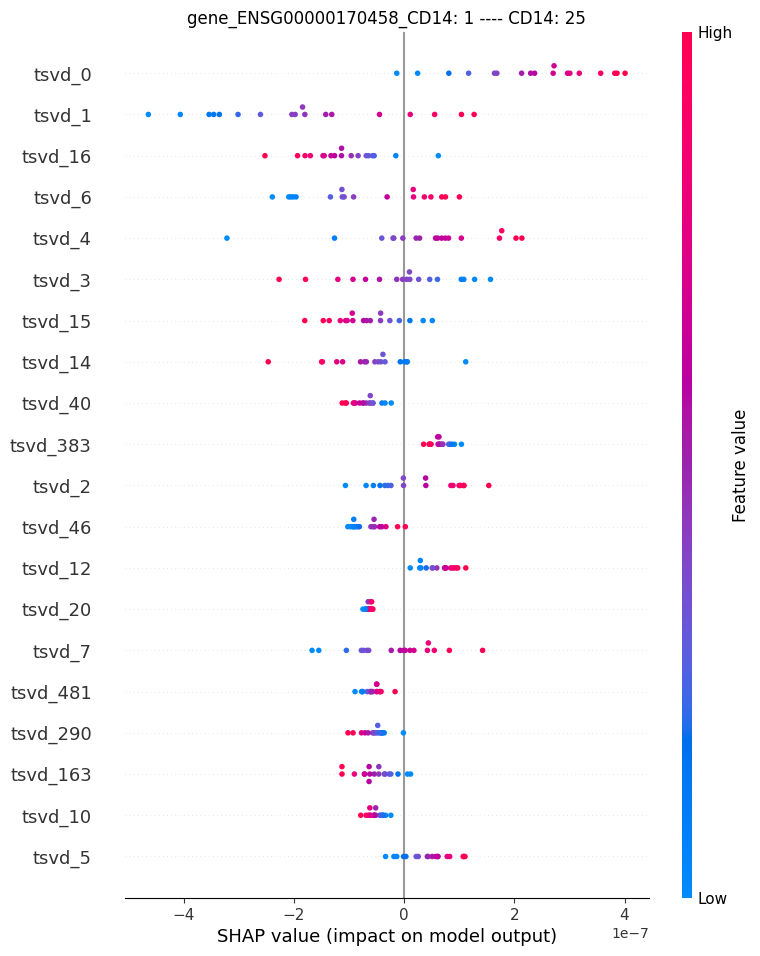

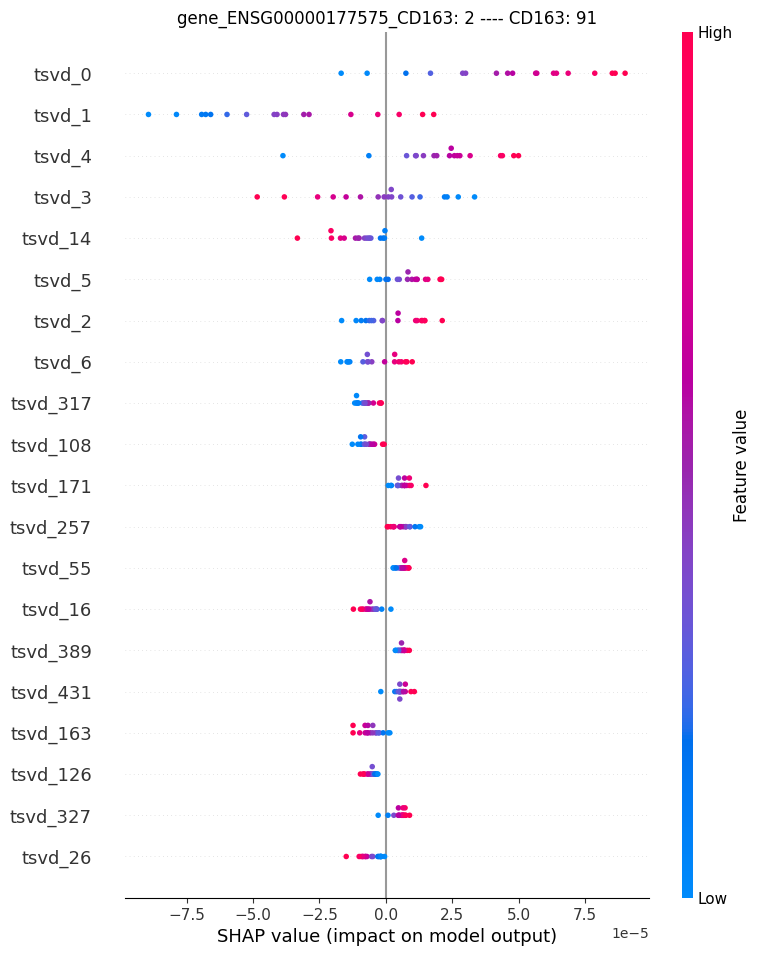

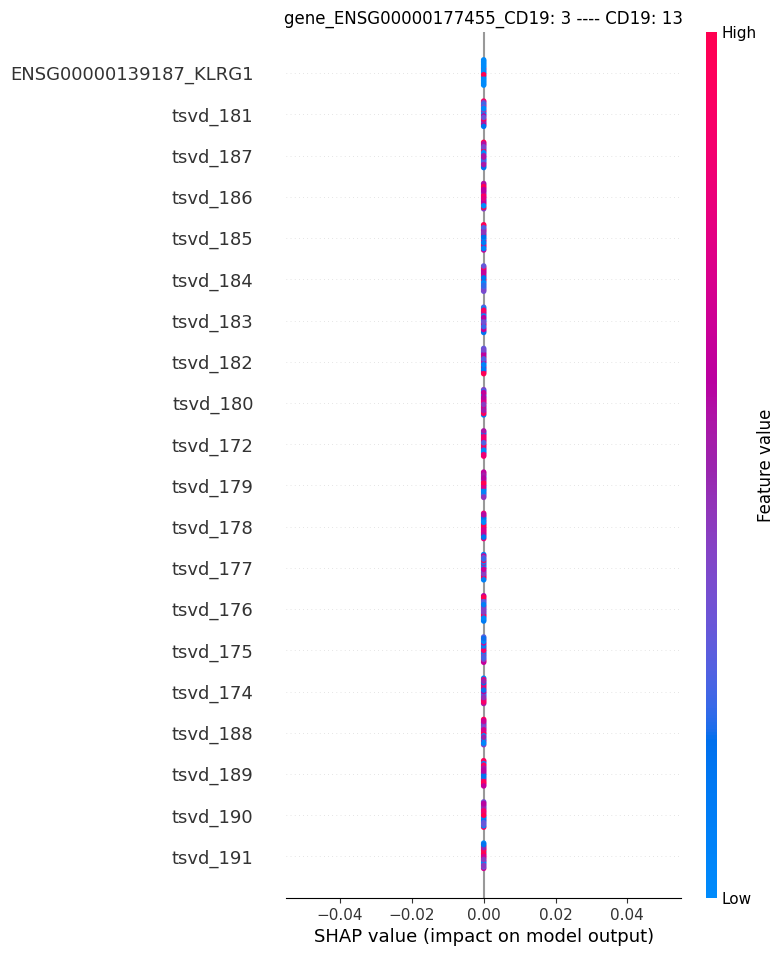

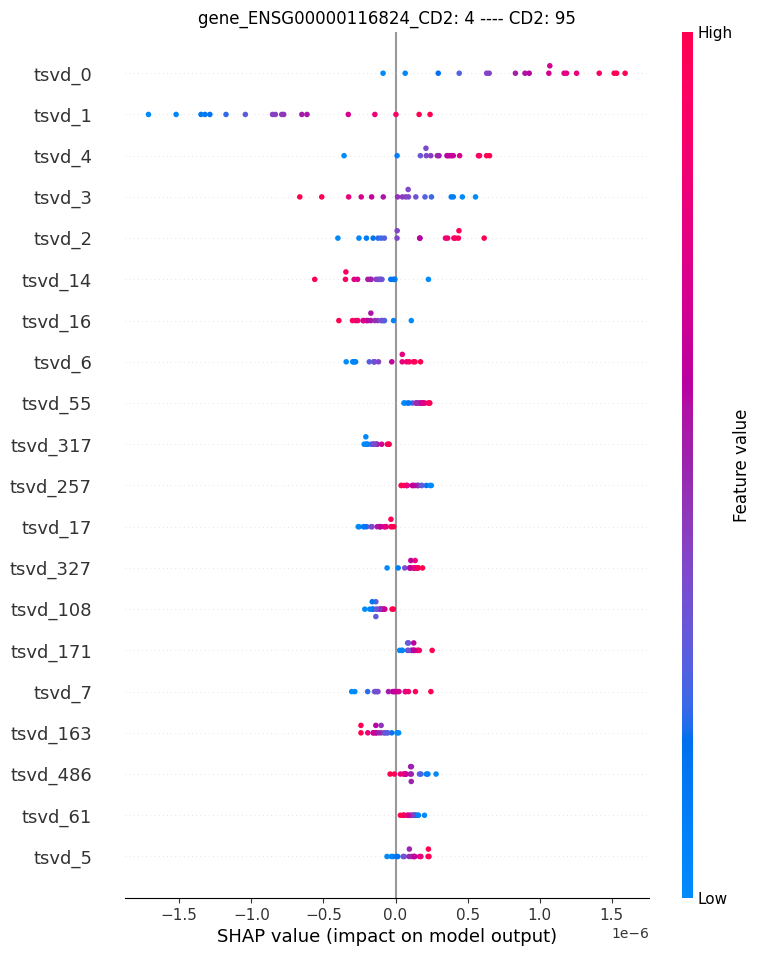

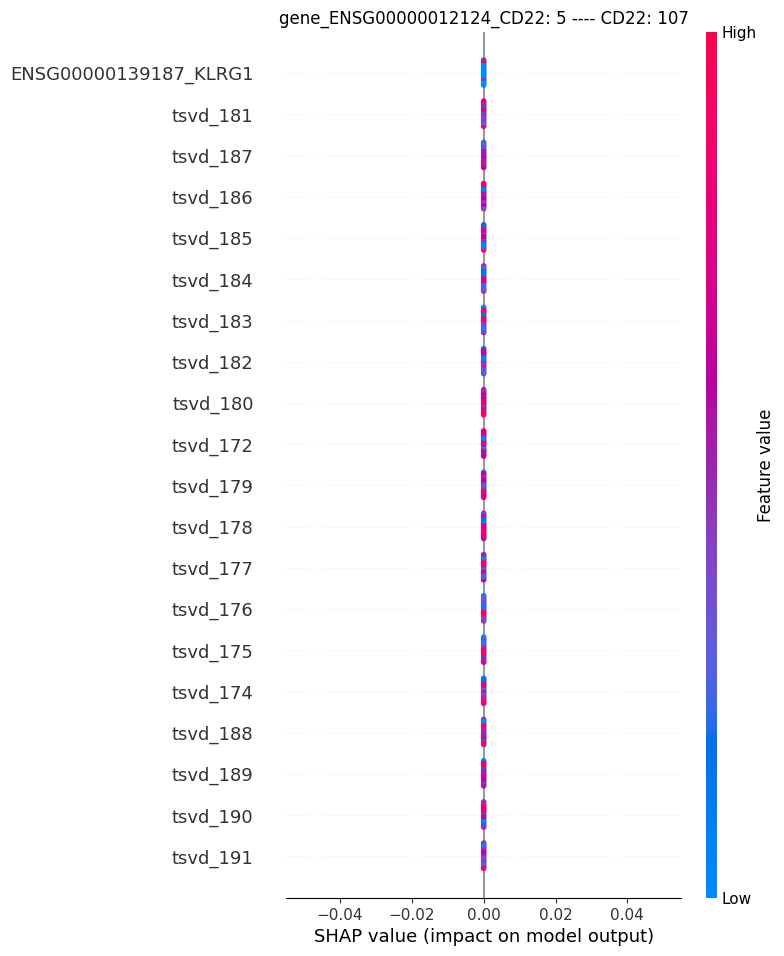

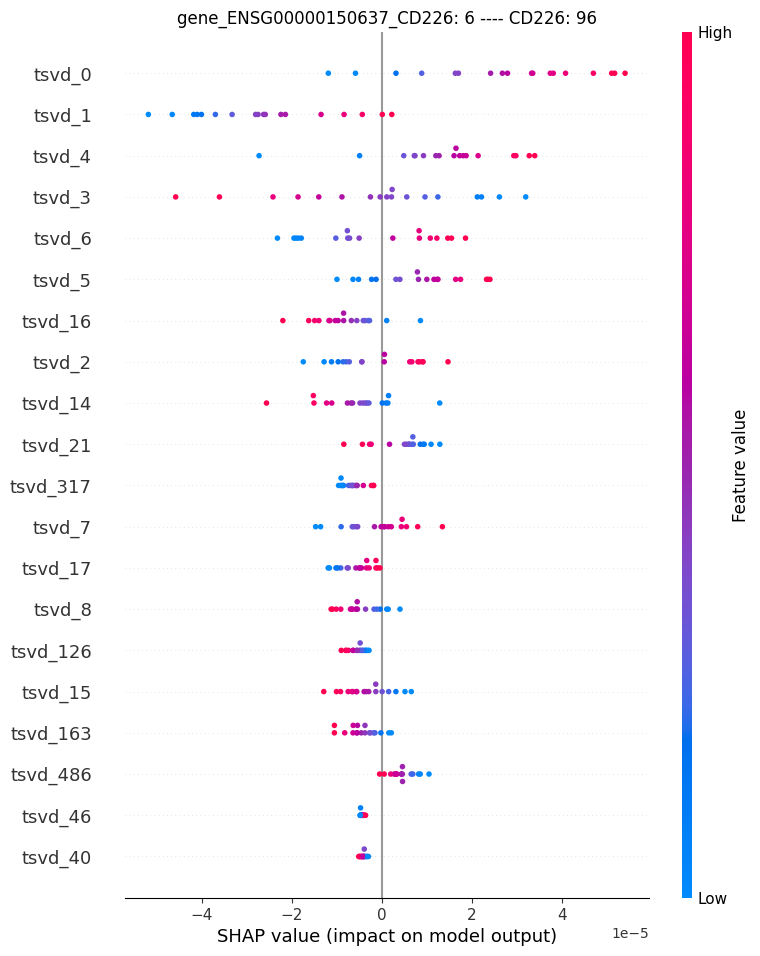

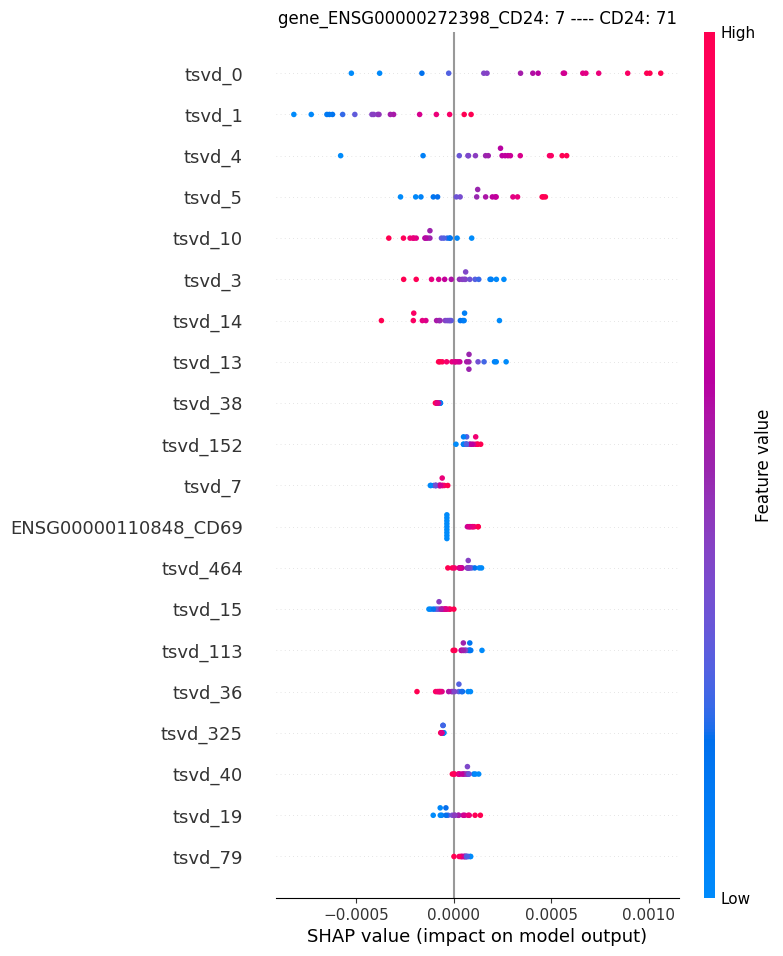

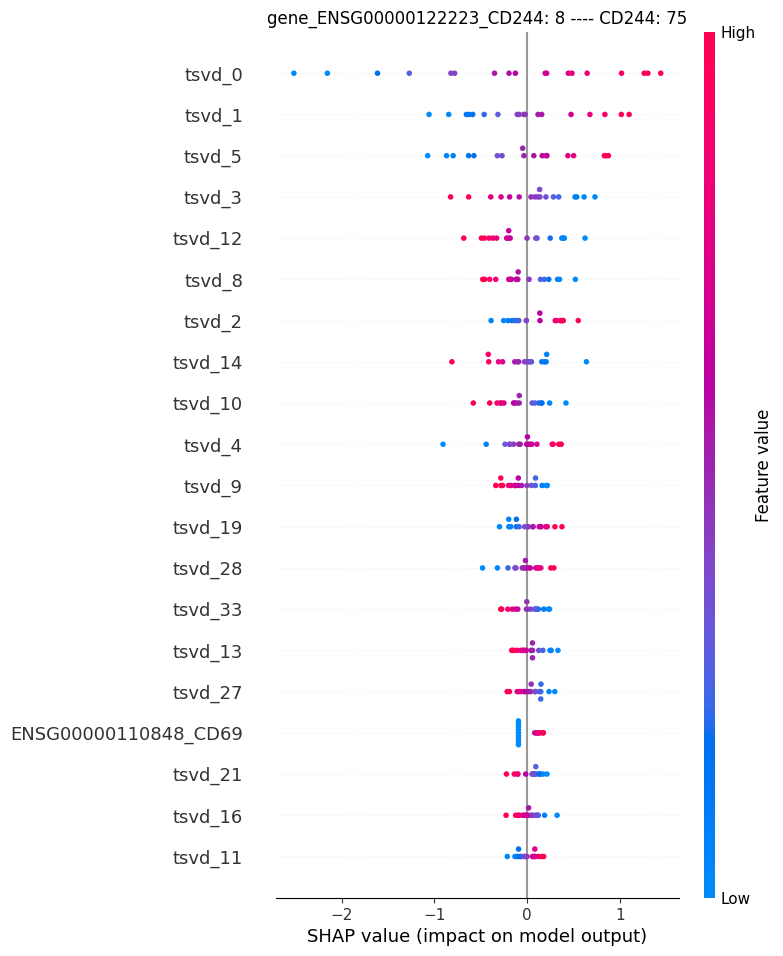

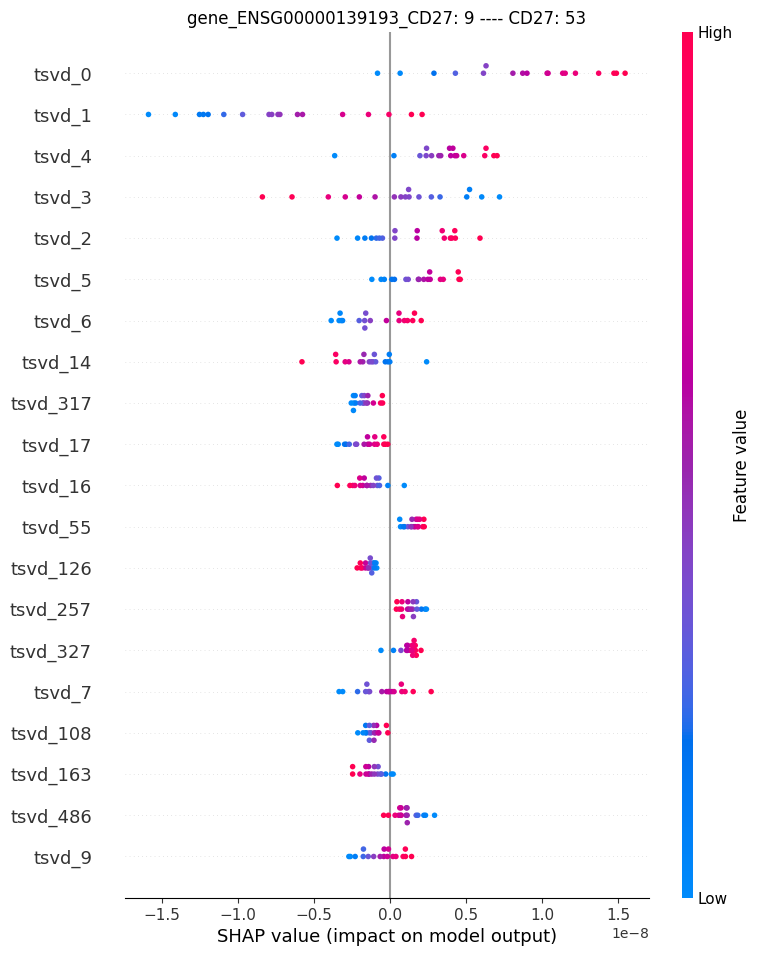

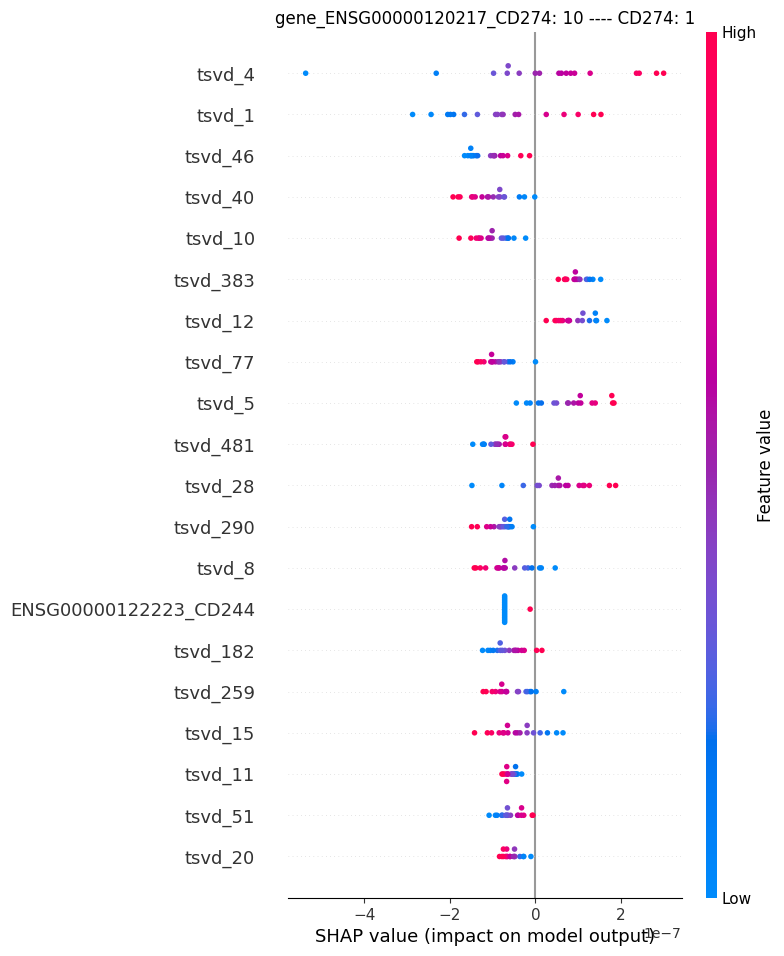

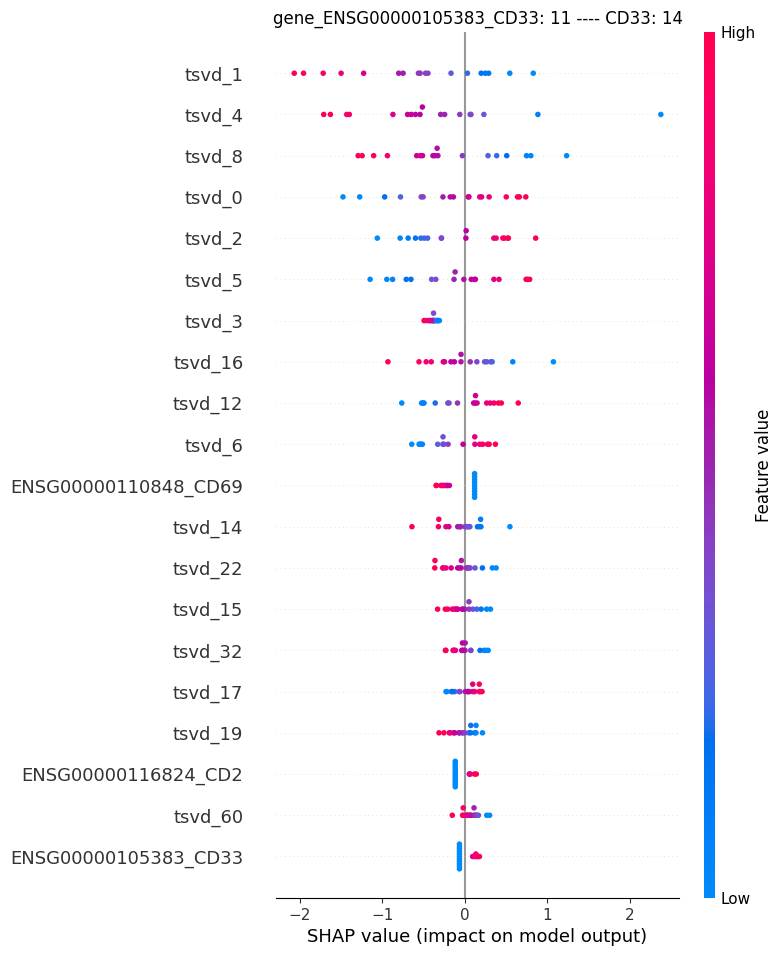

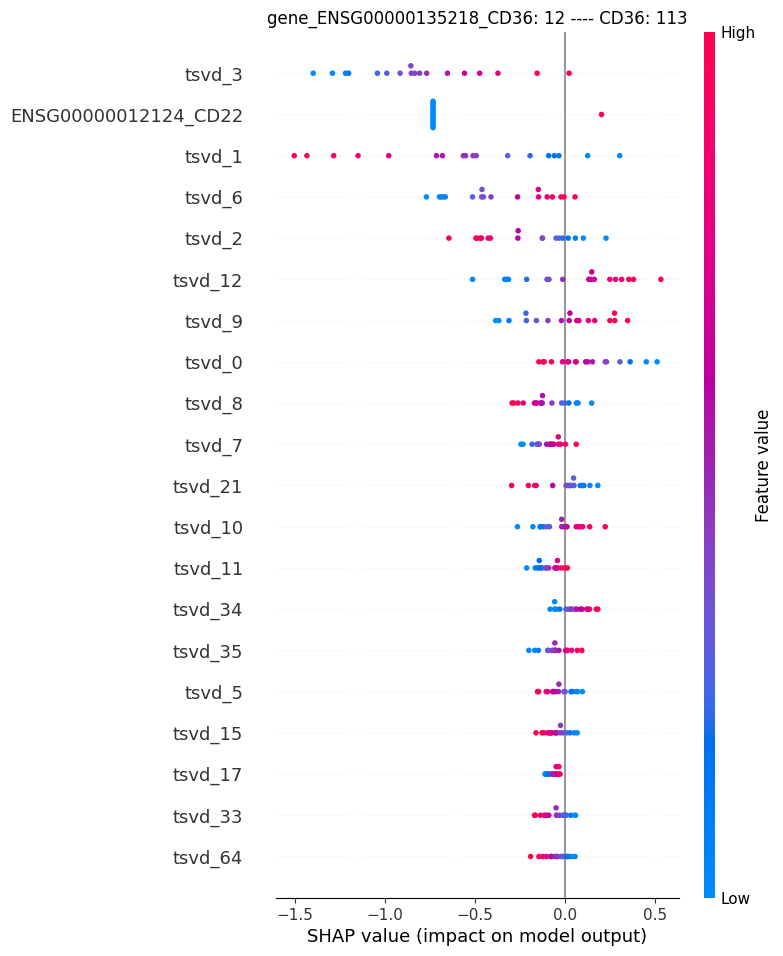

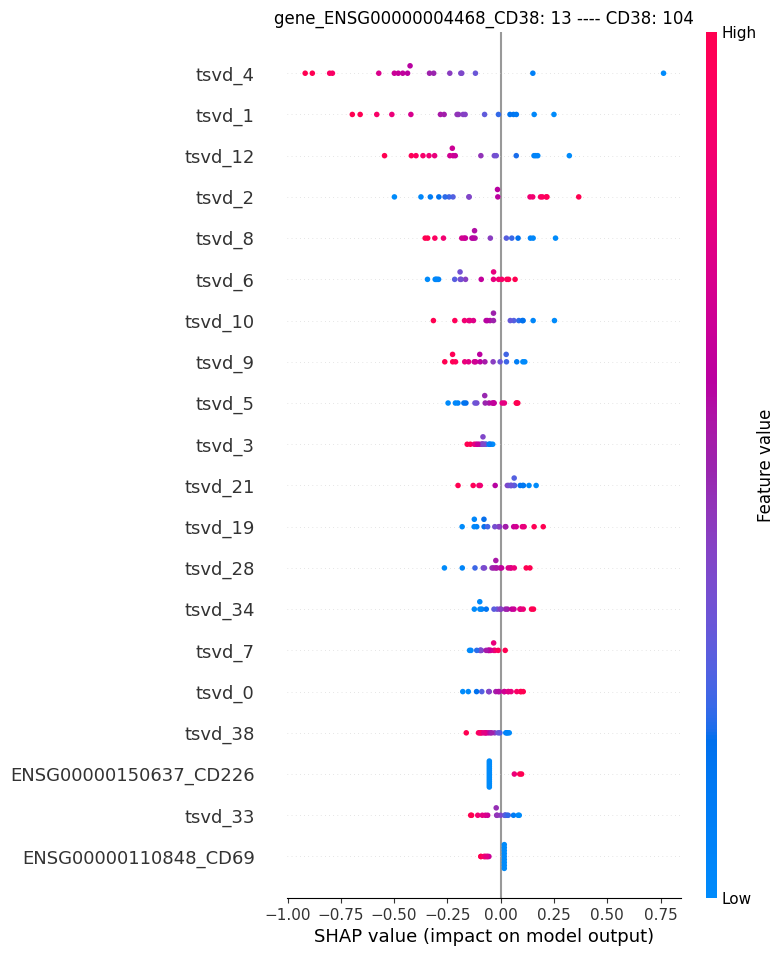

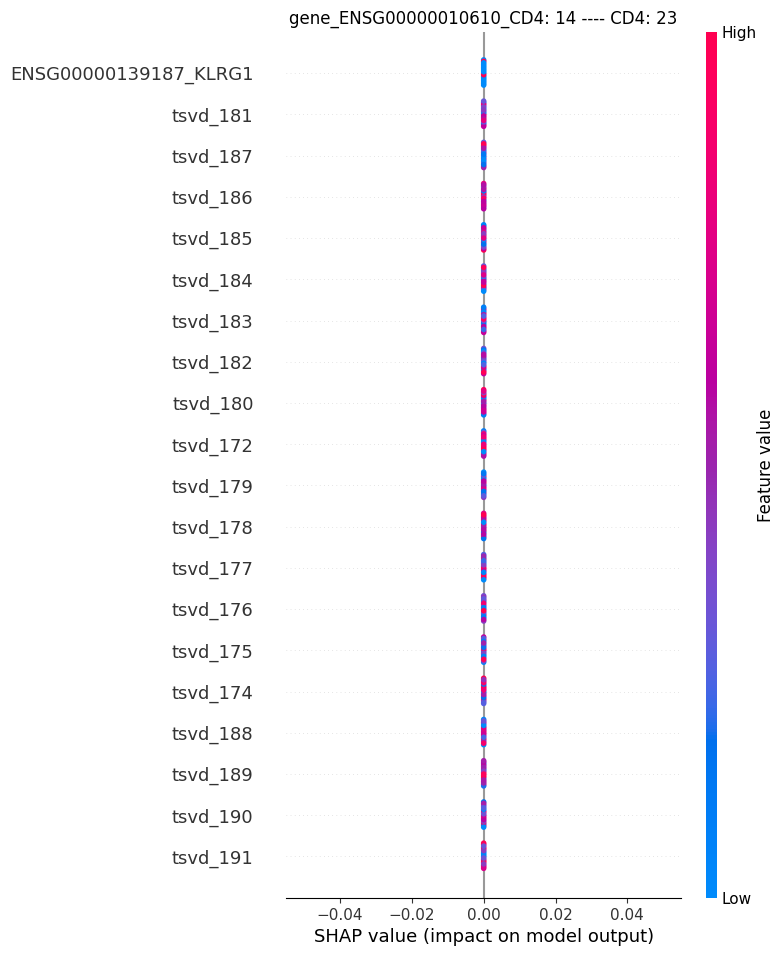

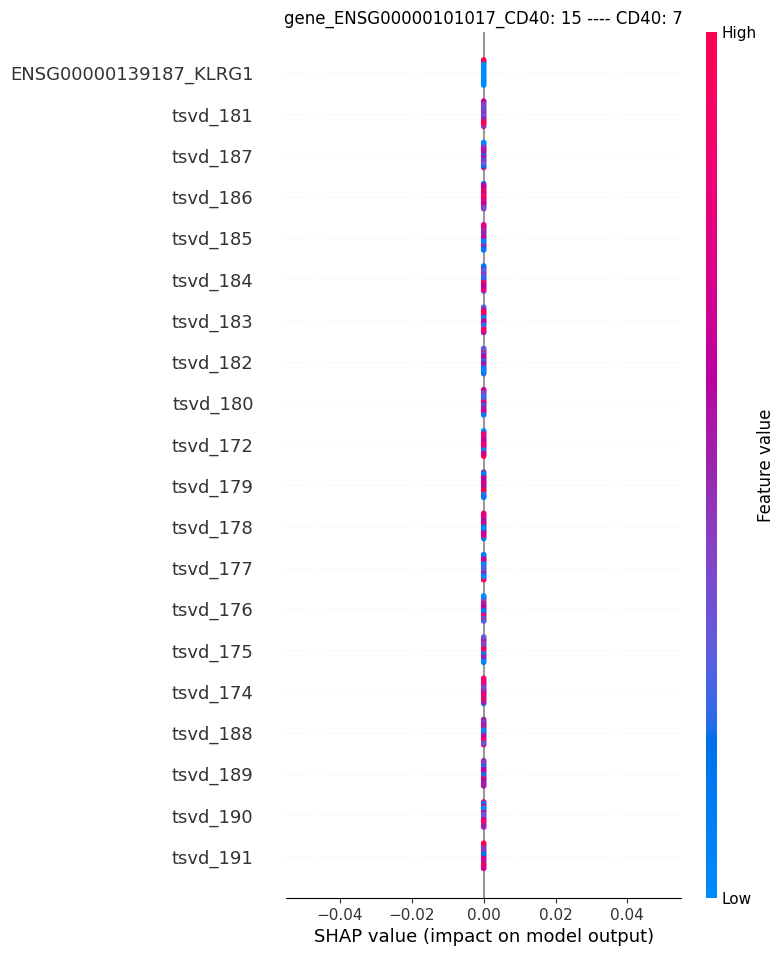

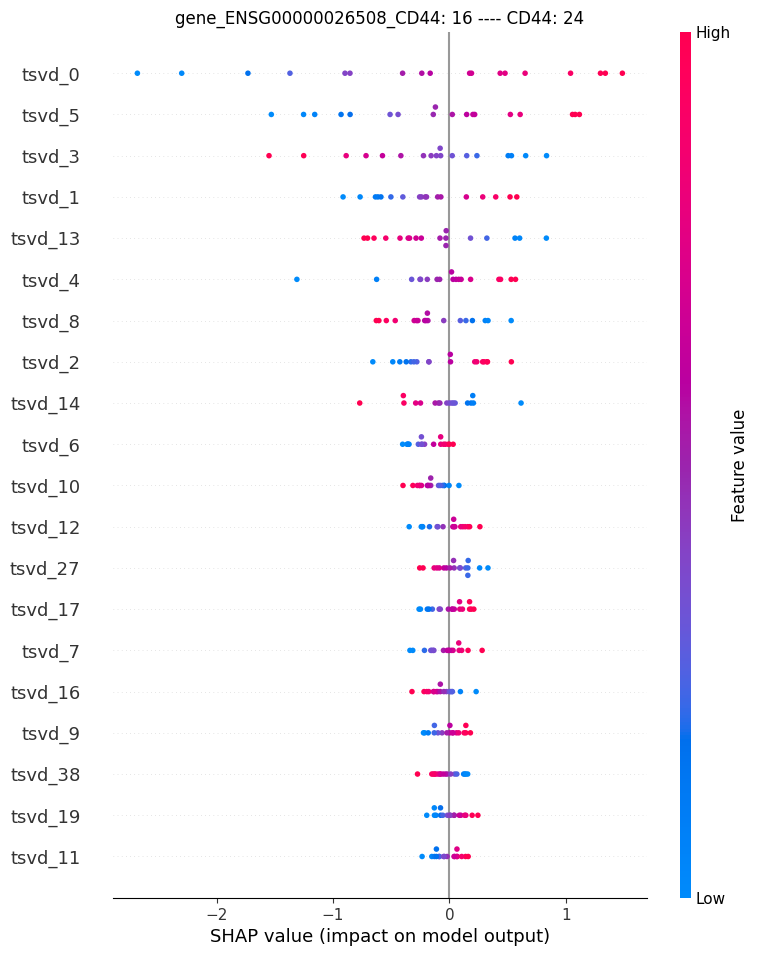

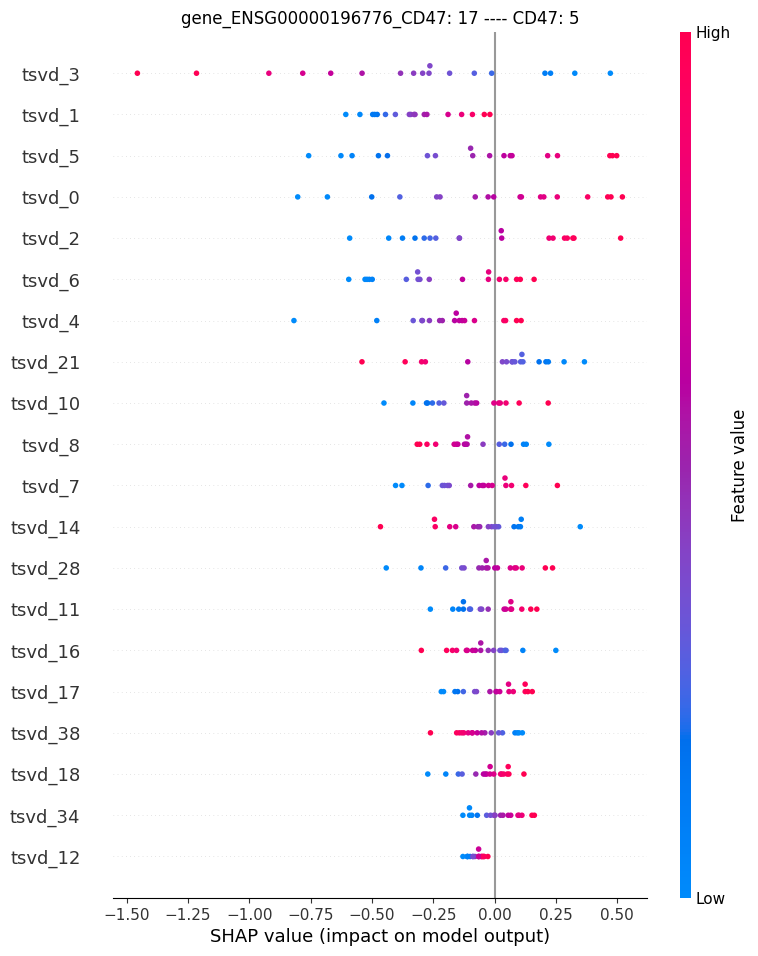

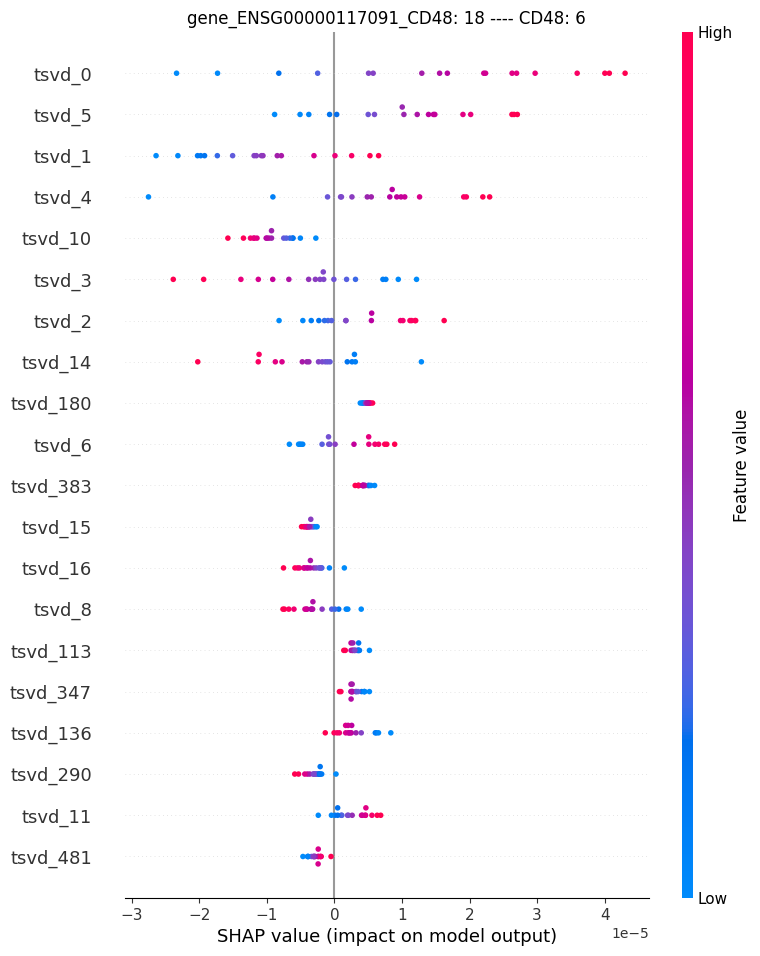

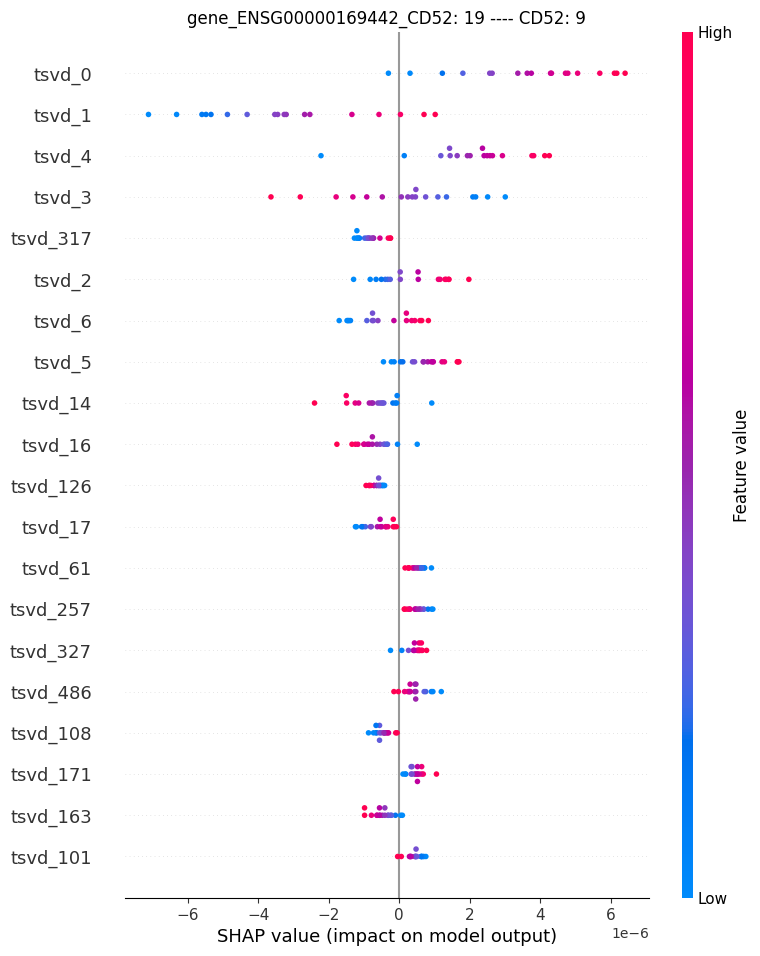

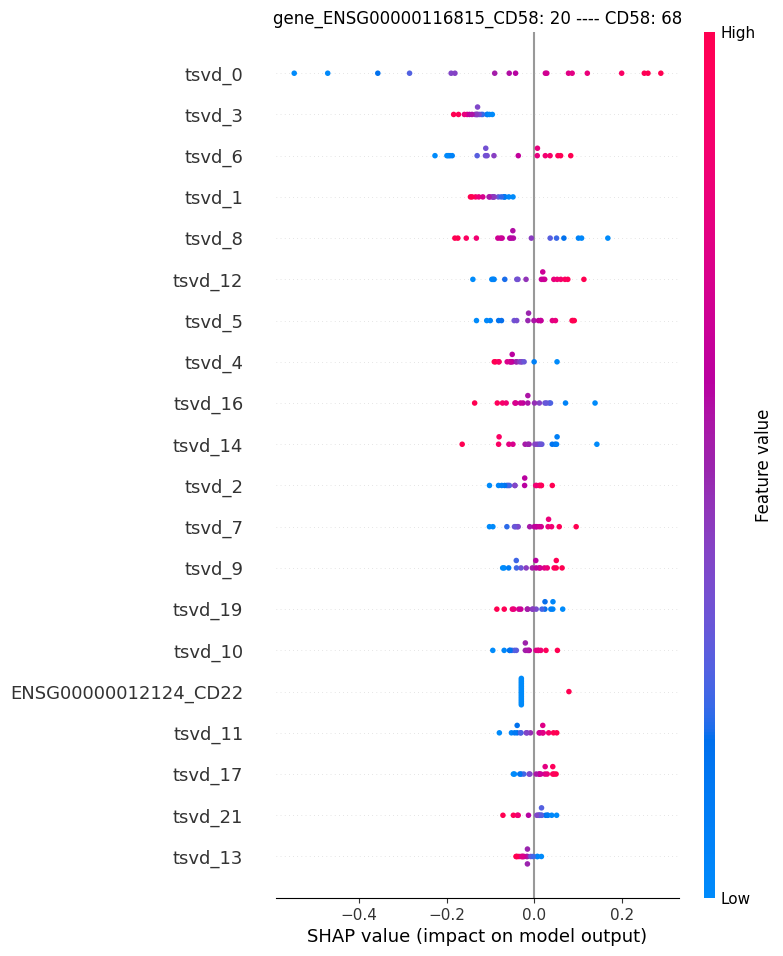

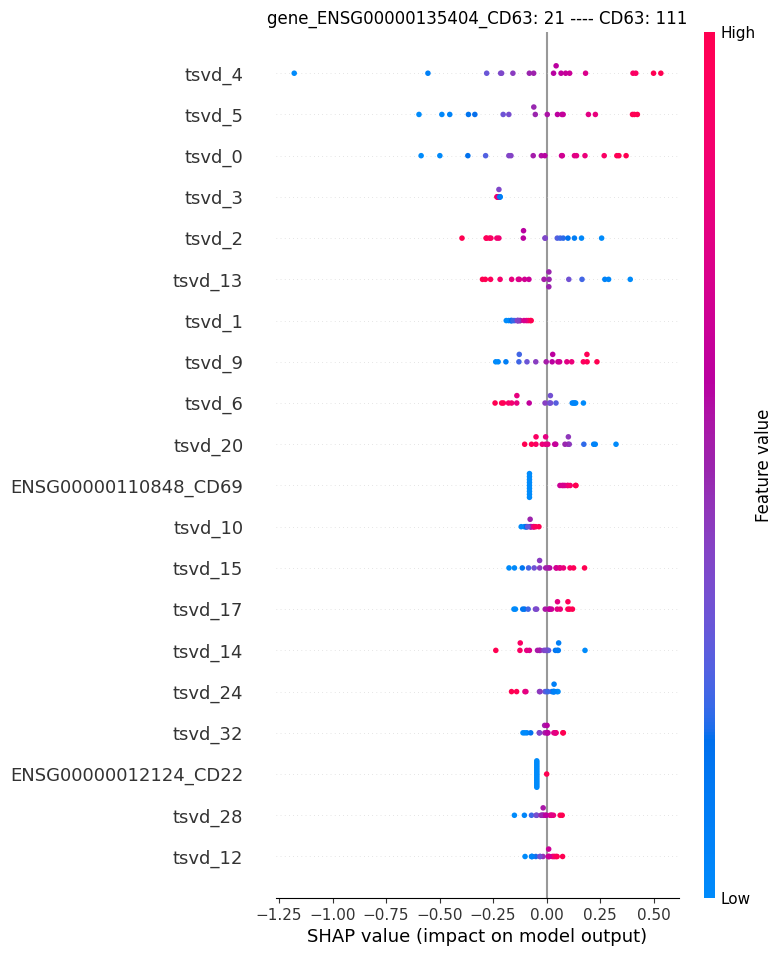

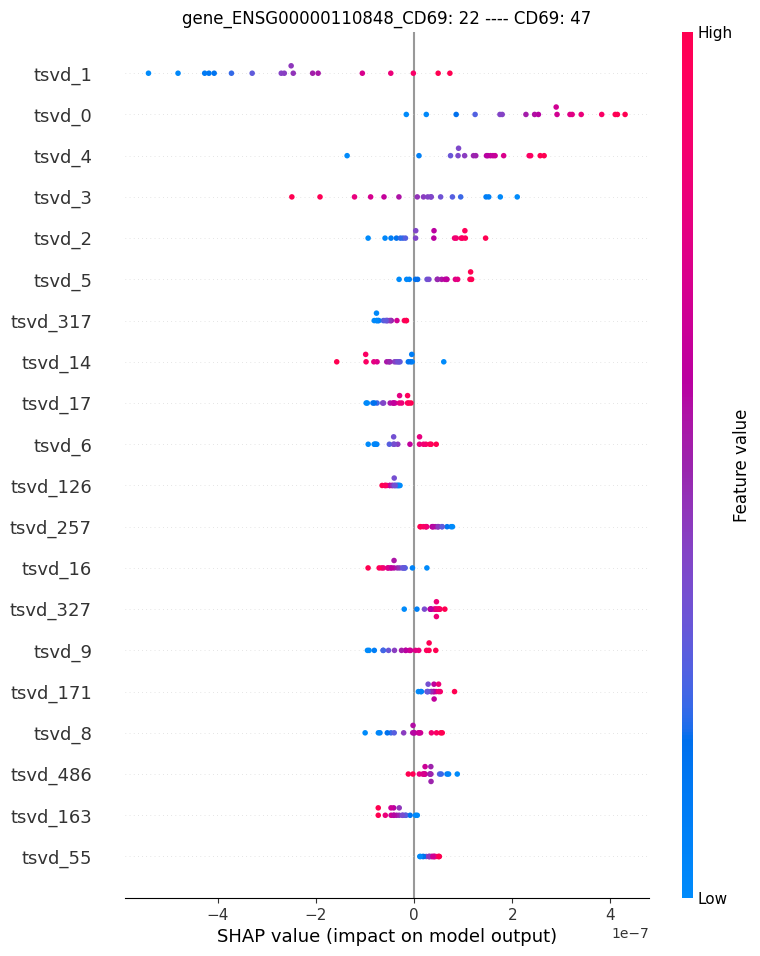

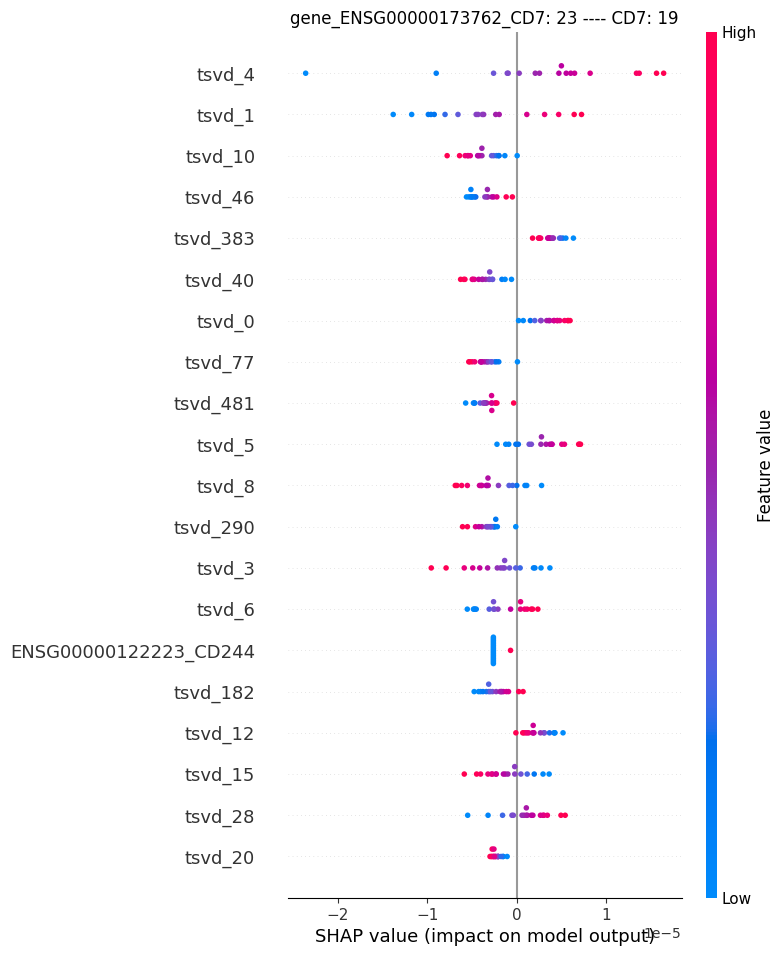

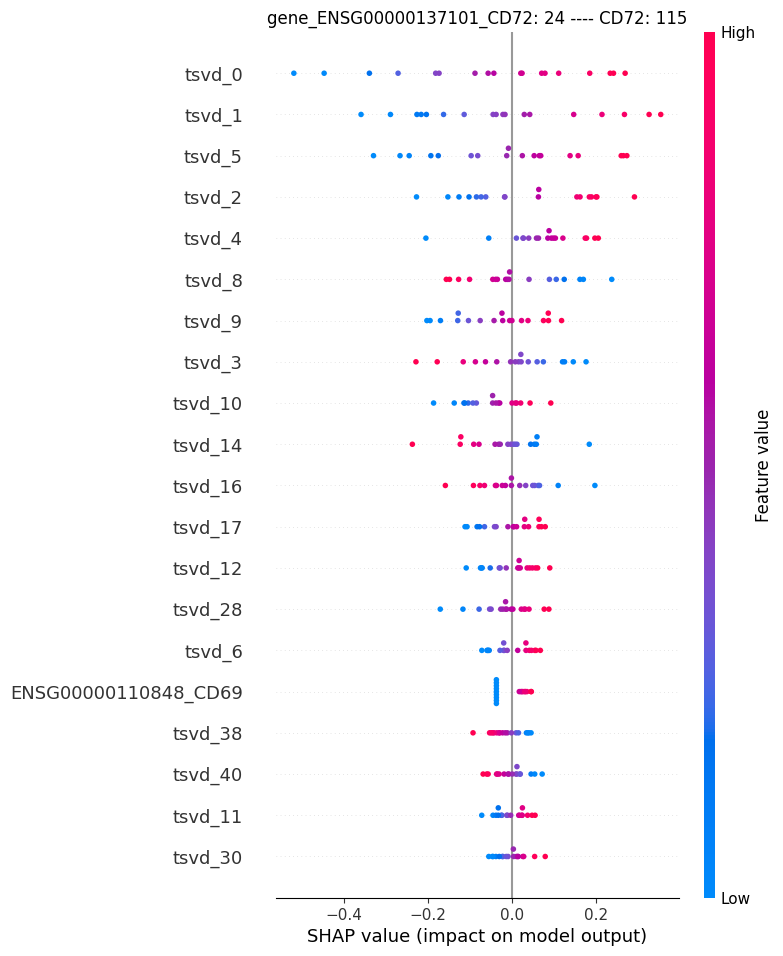

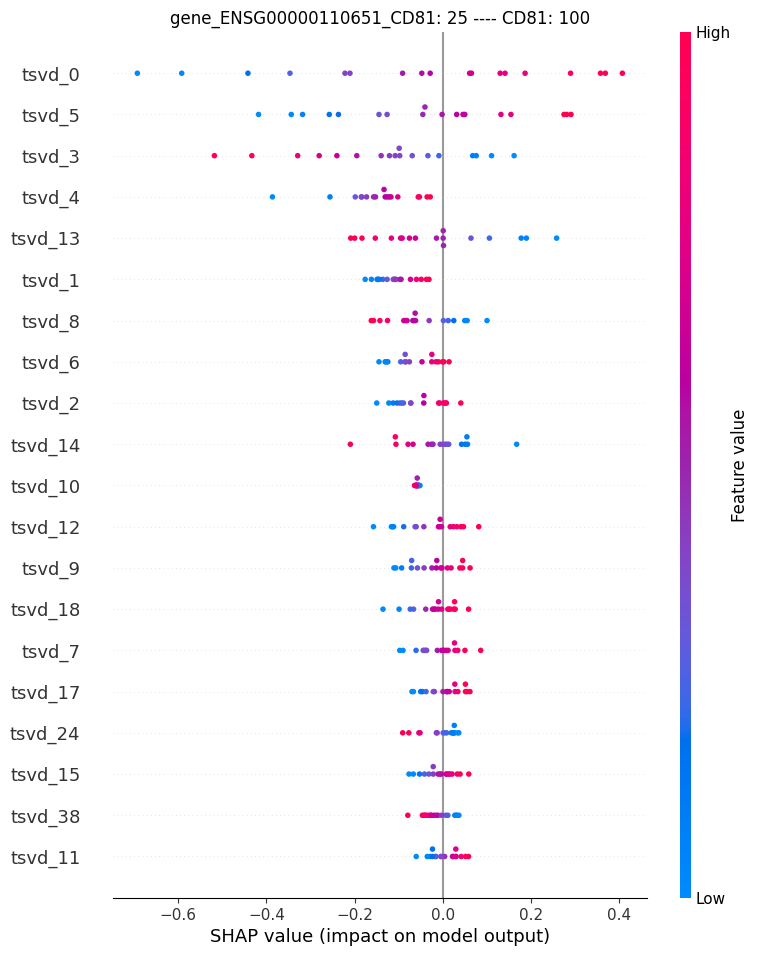

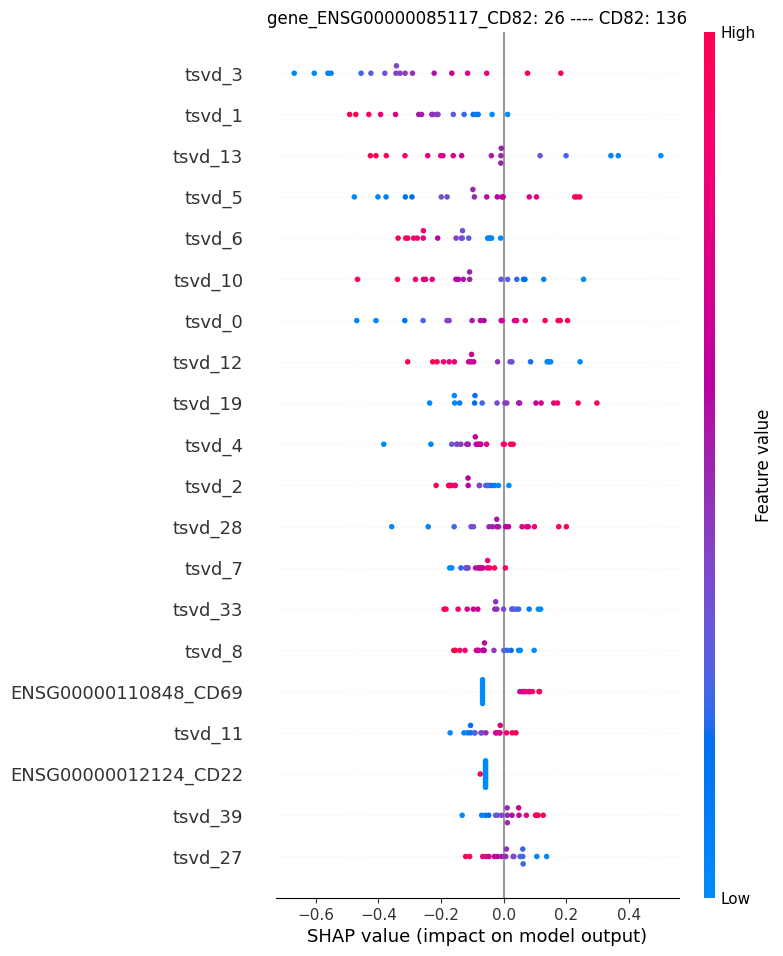

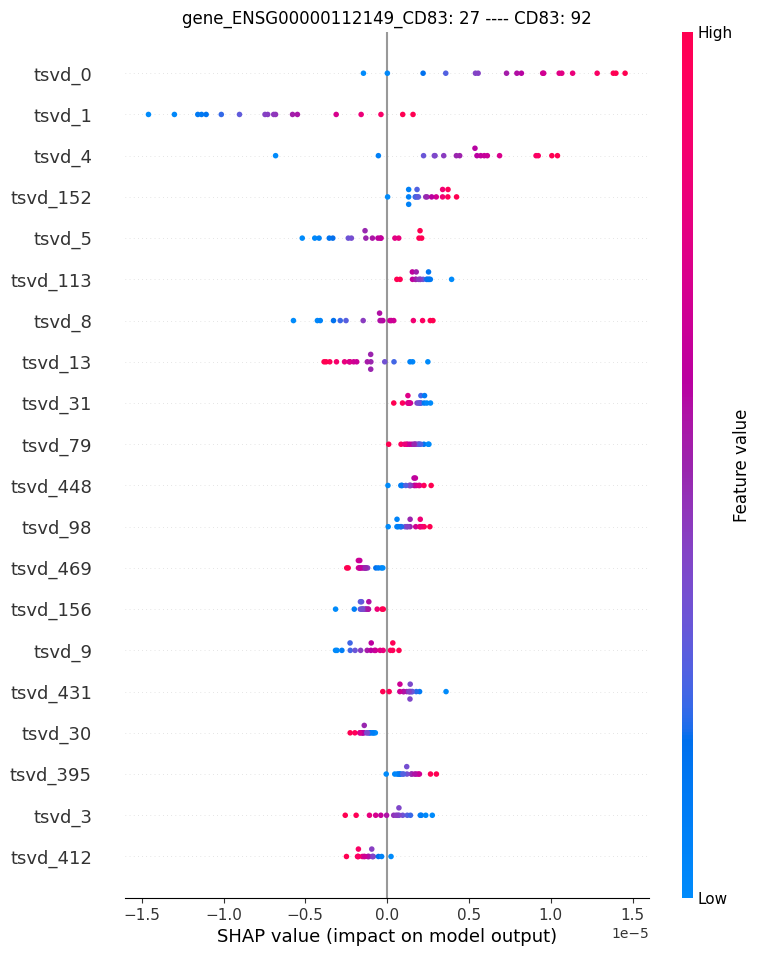

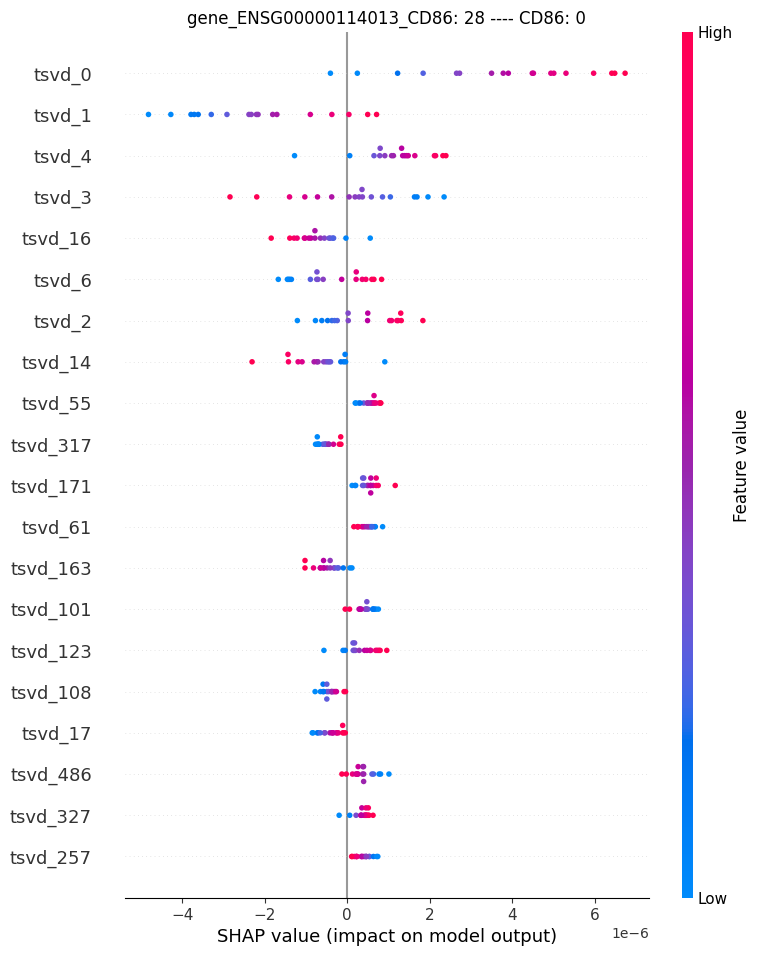

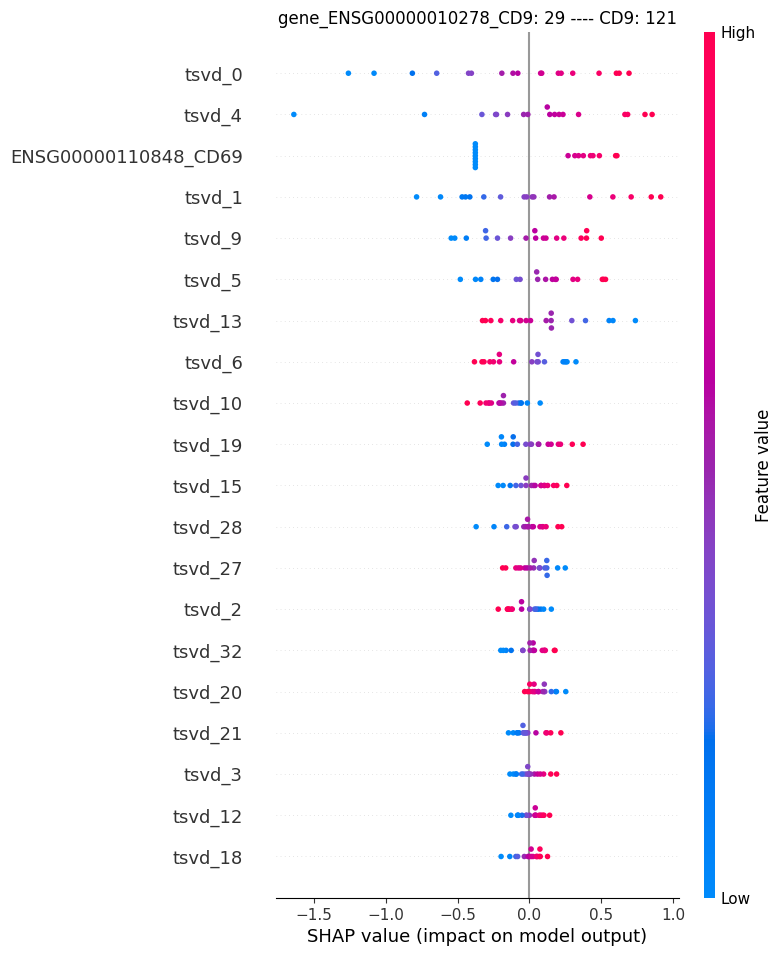

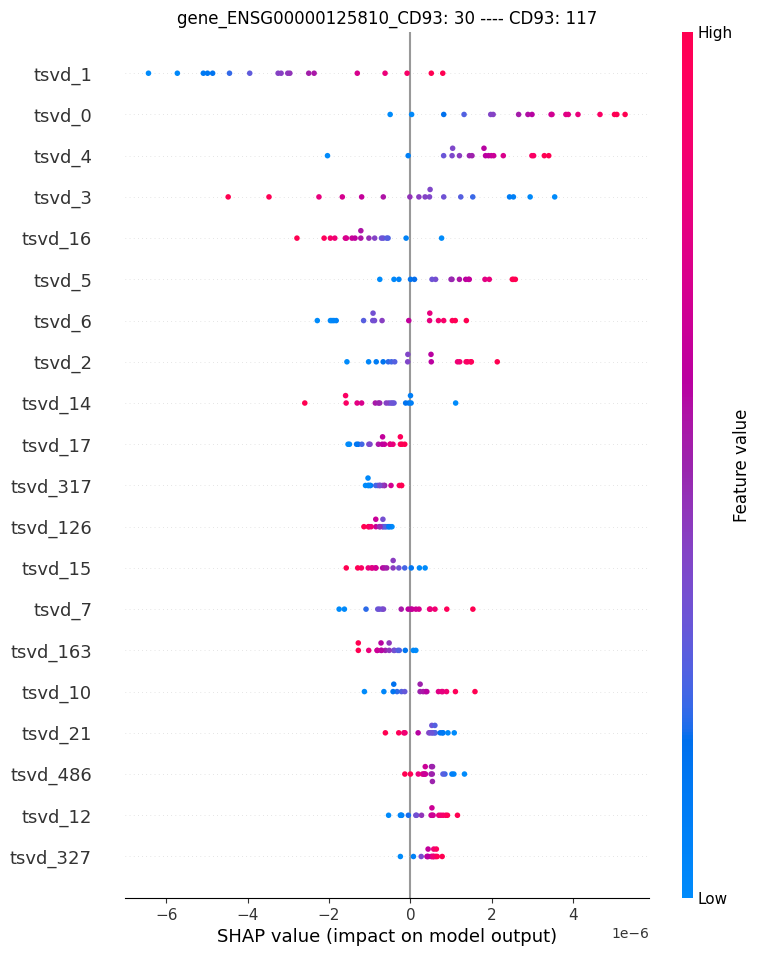

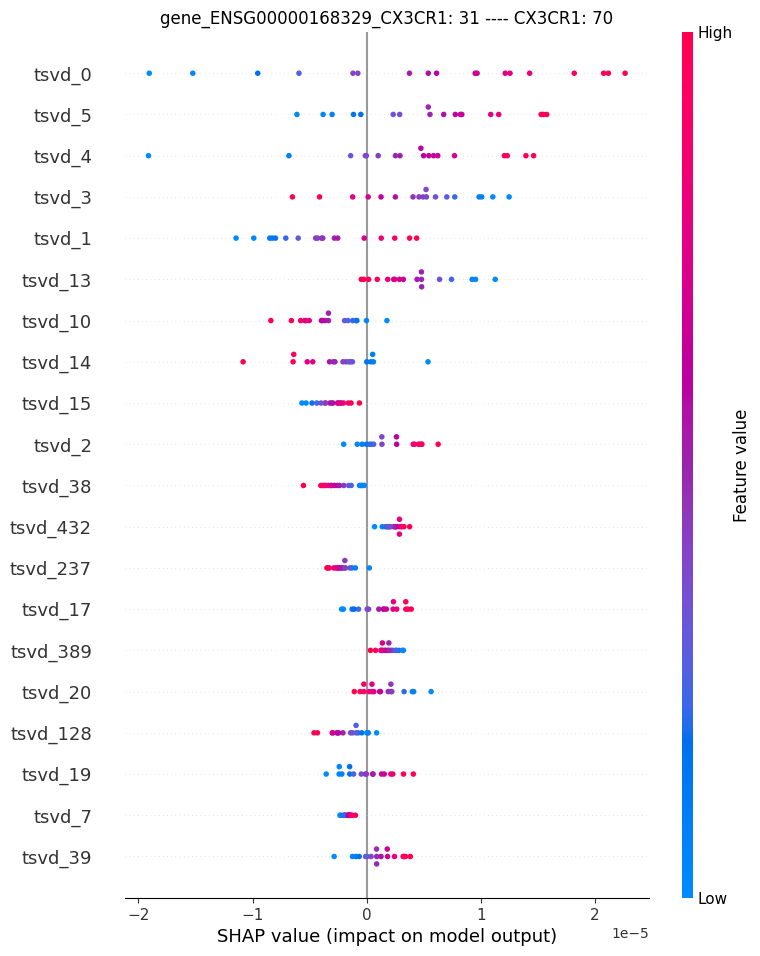

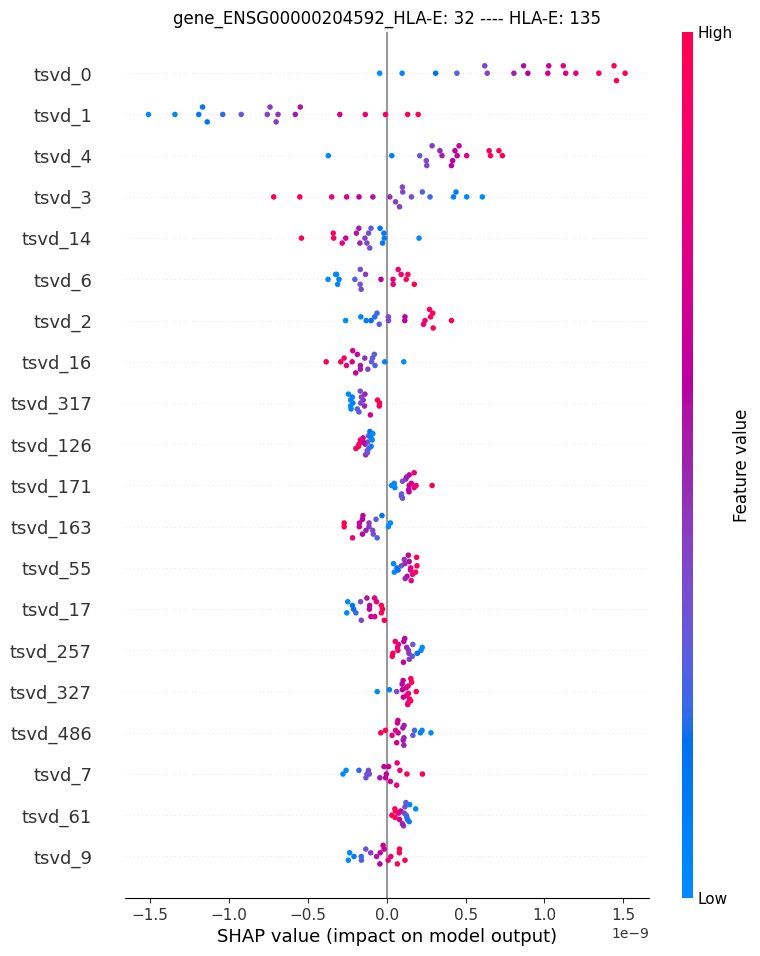

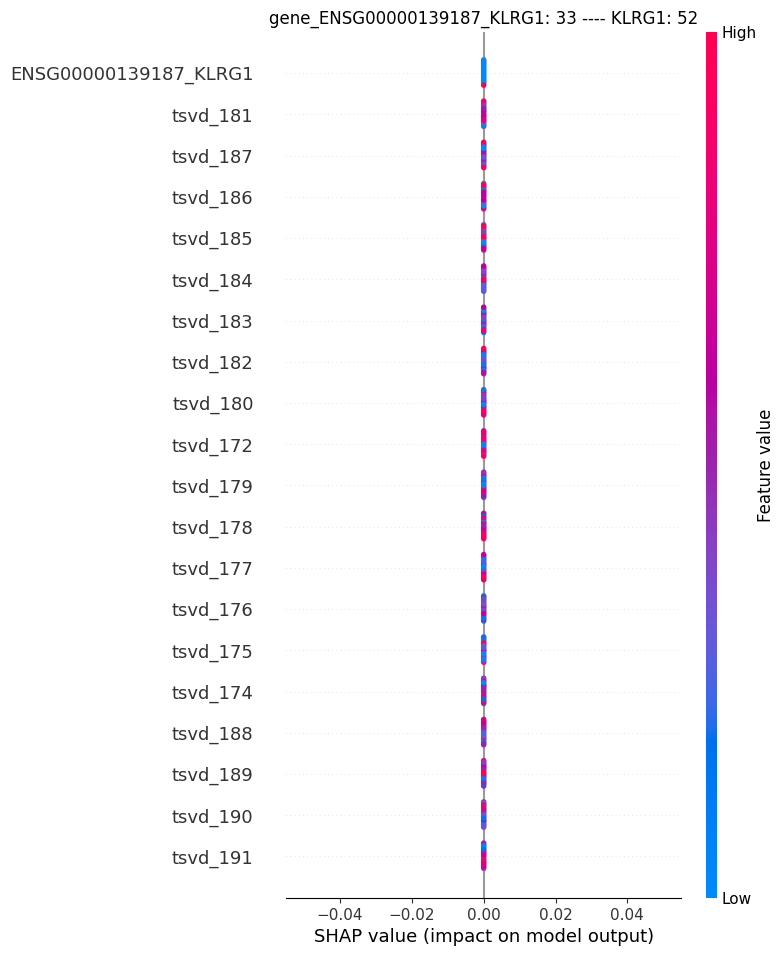

In [ ]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
for key, val in correnspond_gene_pro.items():
  shap.summary_plot(shap_values[key], test, features_names, show=False)
  plt.title(f"{val}")
  plt.savefig(f'/content/shap_plot/shap_{val}.png')
  plt.show()


In [ ]:
correnspond_gene_pro.keys()

dict_keys([137, 25, 91, 13, 95, 107, 96, 71, 75, 53, 1, 14, 113, 104, 23, 7, 24, 5, 6, 9, 68, 111, 47, 19, 115, 100, 136, 92, 0, 121, 117, 70, 135, 52])

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
! mv /content/shap_plot /content/gdrive/MyDrive/CSE529/plots

In [ ]:
x = json.dumps(features_names)
with open("/content/features_names.json", "w") as outfile:
    json.dump(x, outfile)

In [ ]:
print(mlp)

MLP(
  (input_): Linear(in_features=553, out_features=2048, bias=True)
  (fc): Linear(in_features=2048, out_features=2048, bias=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (output): Linear(in_features=512, out_features=140, bias=True)
)


In [ ]:
test_output = mlp(test_input)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
with open('/content/gdrive/MyDrive/CSE529/mlp_test_result.npy', 'wb') as f:
    np.save(f, test_output.detach().numpy())
